In [0]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
P=Path("Images/")
print(P)

machine-learning-online-2018/Datasets/Images/images


In [0]:
!ls Images/

cats  dogs  horses  humans


In [0]:
dirs=P.glob("*")
labels_dict={"cat":0,"dog":1,"horse":2,"human":3}

image_data=[]
labels=[]

for folder_dir in dirs:
#     print(folder_dir)
    label=str(folder_dir).split("/")[-1][:-1]
#     print(label)
    
    for img_path in folder_dir.glob("*.jpg"):
        img=image.load_img(img_path,target_size=(32,32))
        img_array=image.img_to_array(img)
#         print(img_array.shape)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [0]:
print(len(image_data),len(labels))

808 808


In [0]:
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)
print(image_data.shape,labels.shape)


(808, 32, 32, 3) (808,)


In [0]:
# Random shuffling of the data
import random
combined=list(zip(image_data,labels))
random.shuffle(combined)

#unzip
image_data[:],labels[:]=zip(*combined)

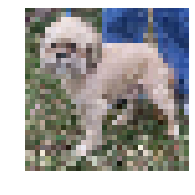

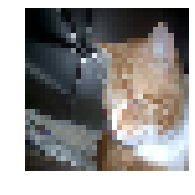

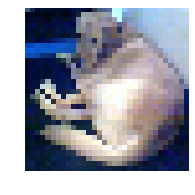

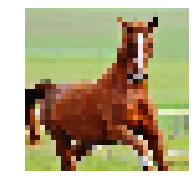

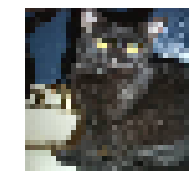

In [0]:
def drawImg(img):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return
for i in range(5):
    drawImg(image_data[i])

In [0]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,maxItr=300):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule that we discussed!
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [0]:
CLASSES=len(np.unique(labels))
print(CLASSES)

4


In [0]:
def classWiseData(x,y):
  M=x.shape[0]  
  data={}
  for i in range(CLASSES):
    data[i]=[]
  x=x.reshape(M,-1)
#   print(x.shape)
  for i in range(M):
    data[y[i]].append(x[i])
  for i in data.keys():
    data[i]=np.array(data[i])
  return data

In [0]:
M=image_data.shape[0]
print(M)
data=classWiseData(image_data,labels)
# print(data[0].shape[0])
# print(data[1].shape[0])
# print(data[2].shape[0])
# print(data[3].shape[0])

808


In [0]:
def getDataPairForSVM(d1,d2):
  l1=d1.shape[0]
  l2=d2.shape[0]
  samples=l1+l2
  features=d1.shape[1]
  
  data_pair=np.zeros((samples,features))
  data_labels=np.zeros((samples,))
  
  data_pair[:l1,:]=d1
  data_pair[l1:,:]=d2
  
  data_labels[:l1]=-1
  data_labels[l1:]= 1
  
  return data_pair,data_labels

In [0]:
mySVM=SVM()

In [0]:
def trainSVMs(x,y):
  svm_classifiers={}
  for i in range(CLASSES):
    svm_classifiers[i]={}
    for j in range(i+1,CLASSES):
      xpair,ypair=getDataPairForSVM(data[i],data[j])
      wts,b,loss=mySVM.fit(xpair,ypair,learning_rate=0.00001,maxItr=1000)
      svm_classifiers[i][j]=(wts,b)
      plt.plot(loss)
      plt.show()
  return svm_classifiers

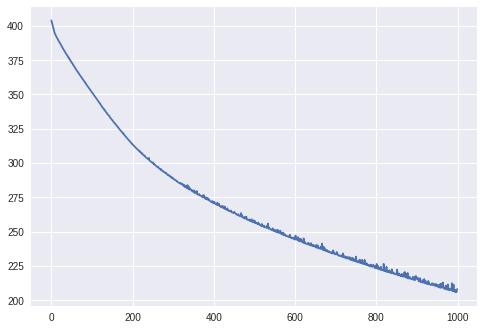

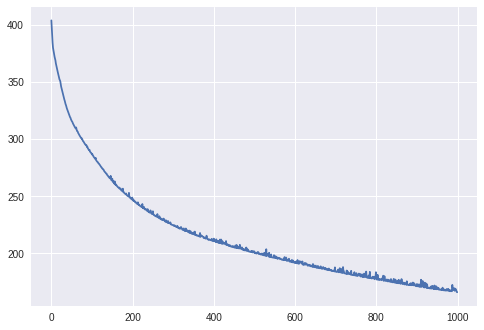

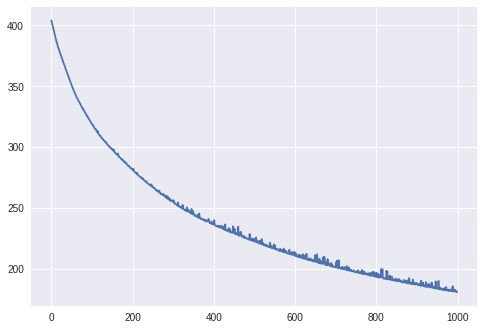

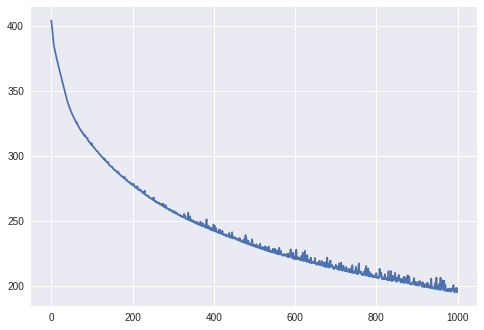

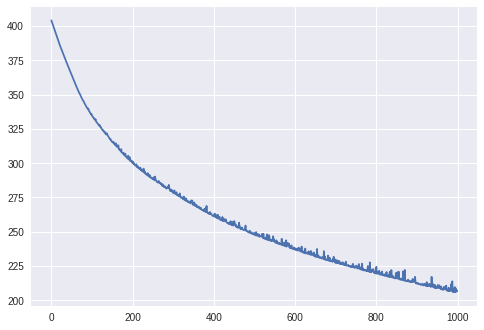

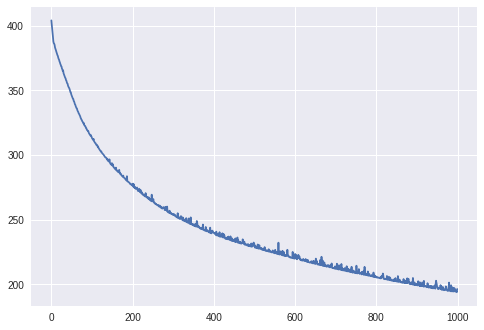

In [0]:
svm_classifiers=trainSVMs(image_data,labels)

In [0]:
def binaryPredict(x,w,b):
    x=np.reshape(x,(1,-1))
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [0]:
def predict(x):
  count=np.zeros((CLASSES,))
  
  for i in range(CLASSES):
    
    for j in range(i+1,CLASSES):
        wts,b=svm_classifiers[i][j]
#         print(x.shape,wts.shape)
        z=binaryPredict(x,wts,b)
        
        if z==1:
          count[j]+=1
        else:
          count[i]+=1
        
 
  final_prediction=np.argmax(count)
  return final_prediction
      

In [0]:
print(predict(image_data[100]))
# print(image_data[0].shape)
print(labels[100])

0
0


In [0]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [0]:
print(accuracy(image_data,labels))

0.5928217821782178
